<a href="https://colab.research.google.com/github/mehdimashayekhi/Generative-models/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A simple implementaion of GAN paper!

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from keras.datasets.mnist import load_data

In [20]:
# # load (and normalize) mnist dataset
(trainX, trainy),(testX, testy) = load_data()
trainX = (np.float32(trainX) - 127.5) / 127.5

In [21]:
def get_minibatch(batch_size):
    indices = torch.randperm(trainX.shape[0])[:batch_size]
    return torch.tensor(trainX[indices], dtype=torch.float).reshape(batch_size, -1)

In [22]:
def sample_noise(size, dim=100):
    out = torch.empty(size, dim)
    mean = torch.zeros(size, dim)
    std = torch.ones(dim)
    torch.normal(mean, std, out=out)
    return out

In [23]:
class Generator(nn.Module):
    def __init__(self, input_dim=100, hidden_dim=1200, output_dim=28*28):
        super(Generator, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Tanh(),
        )

    def forward(self, noise):
        return self.network(noise)  

In [24]:
class Discriminator(nn.Module):

    def __init__(self, input_dim=28 * 28, hidden_dim=240, output_dim=1):
        super(Discriminator, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid(), )

    def forward(self, x):
        return self.network(x)

In [25]:
def train(generator, discriminator, generator_optimizer, discriminator_optimizer, nb_epochs, k=1, batch_size=100):
    training_loss = {'generative': [], 'discriminator': []}
    for epoch in tqdm(range(nb_epochs)):

        # Train the disciminator
        for _ in range(k):
            # Sample a minibatch of m noise samples
            z = sample_noise(batch_size).to(device)
            # Sample a minibatch of m examples from the data generating distribution
            x = get_minibatch(batch_size).to(device)

            # Update the discriminator by ascending its stochastic gradient
            f_loss = torch.nn.BCELoss()(discriminator(generator(z)).reshape(batch_size),
                                        torch.zeros(batch_size, device=device))
            r_loss = torch.nn.BCELoss()(discriminator(x).reshape(batch_size), torch.ones(batch_size, device=device))
            loss = (r_loss + f_loss) / 2
            discriminator_optimizer.zero_grad()
            loss.backward()
            discriminator_optimizer.step()
            training_loss['discriminator'].append(loss.item())

        # Train the generator

        # Sample a minibatch of m noise samples
        z = sample_noise(batch_size).to(device)
        # Update the generator by descending its stochastic gradient
        loss = torch.nn.BCELoss()(discriminator(generator(z)).reshape(batch_size),
                                  torch.ones(batch_size, device=device))
        generator_optimizer.zero_grad()
        loss.backward()
        generator_optimizer.step()
        training_loss['generative'].append(loss.item())

    return training_loss

In [26]:
if torch.cuda.is_available():  
  device = "cuda" 
else:  
  device = "cpu"  
print(device)

cuda


In [32]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)

optimizer_d = optim.SGD(discriminator.parameters(), lr=0.1, momentum=0.5)
optimizer_g = optim.SGD(generator.parameters(), lr=0.1, momentum=0.5)

loss = train(generator, discriminator, optimizer_g, optimizer_d, 15000, batch_size=100)



100%|██████████| 15000/15000 [02:31<00:00, 99.30it/s] 


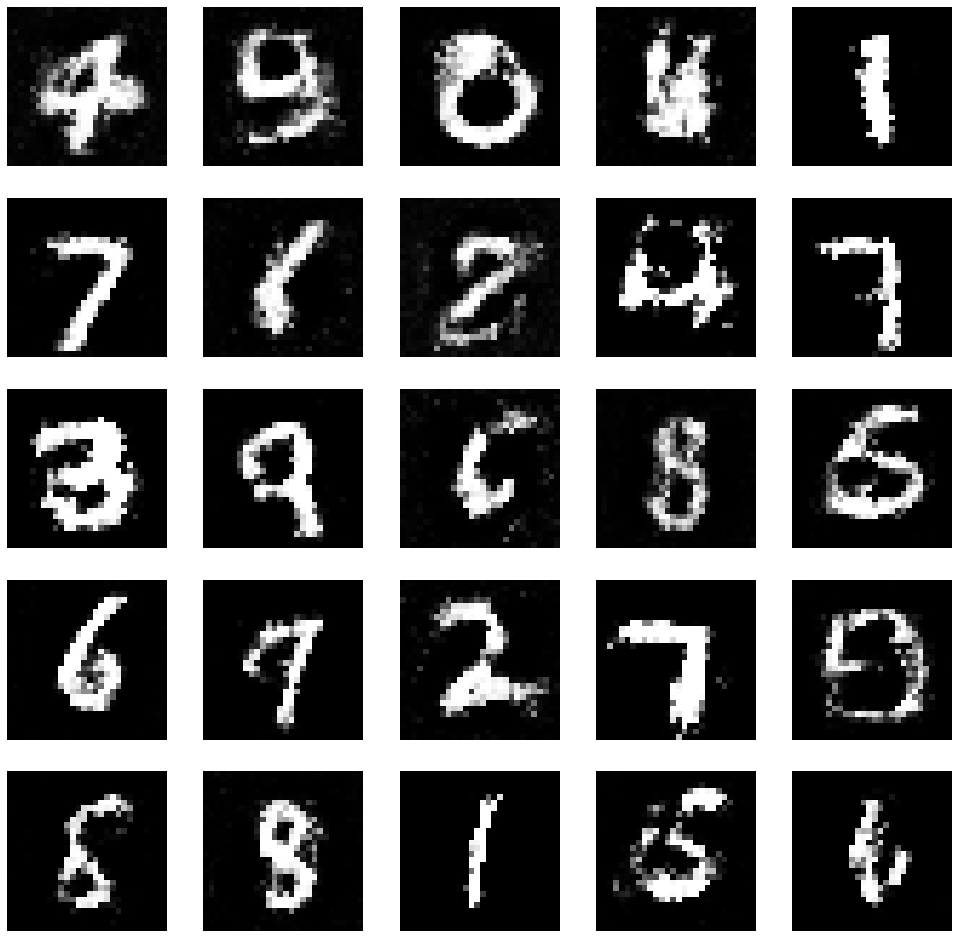

In [33]:
# Sample and plot images from the trained generator
NB_IMAGES = 25
z = sample_noise(NB_IMAGES).to(device)
x = generator(z)
plt.figure(figsize=(17, 17))
for i in range(NB_IMAGES):
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    plt.imshow(x[i].data.cpu().numpy().reshape(28, 28), cmap='gray')
# plt.savefig("Imgs/regenerated_MNIST_data.png")
plt.show()


That was fun, if you want to gete better results, you can train it longer!!